# Analysis of user behavior in a mobile application for purchasing products

## Introduction

User behavior in mobile applications depends on many factors and, as a result, varies significantly. To increase sales and revenue, it is necessary to make the right decisions regarding the functionality and design of such applications. Therefore, it is essential to carefully analyze user actions, formulate hypotheses for improving the product, and conduct tests.

This project is aimed at analyzing user behavior in the mobile application of a startup that allows ordering food products. Among the project's goals are:

- General study of user behavior.
- Studying the sales funnel and determining the number of users who have reached the purchase stage, as well as identifying "problematic" steps.
- Analyzing the results of an A/A/B test to make a decision on changing fonts in the application.

To achieve the project goals, data on user events and actions will be uploaded, preprocessed, and analyzed. An event funnel will be defined, and the number of users at each step will be calculated. Next, the A/A/B test groups will be studied, the most popular event will be identified, and statistical hypotheses about the difference in user behavior in different groups will be formulated and tested. Finally, a general conclusion describing the results of the analysis will be drawn.

## Step 1. Imports and Data Upload

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from scipy import stats as st

In [2]:
pio.renderers.default = "png"

In [3]:
data = pd.read_csv('./datasets/logs_exp.csv', sep='\t')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


The dataset contains 4 fields with information about events and actions:

- Event name
- User ID
- Event time
- Experiment number: 246 and 247 are control groups, while 248 is the experimental group.

There are 244,126 records in the dataset.

## Step 2. Data Preprocessing

In [6]:
data.columns = ['event_name', 'user_id', 'event_datetime', 'group']
data.head()

,event_name,user_id,event_datetime,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [7]:
print('Missing values count:')
data.isna().sum()

Missing values count:


event_name        0
user_id           0
event_datetime    0
group             0
dtype: int64

In [8]:
data['event_datetime'] = pd.to_datetime(data['event_datetime'], unit='s')
data['event_datetime'].head()

0   2019-07-25 04:43:36
1   2019-07-25 11:11:42
2   2019-07-25 11:28:47
3   2019-07-25 11:28:47
4   2019-07-25 11:48:42
Name: event_datetime, dtype: datetime64[ns]

In [9]:
data['date'] = data['event_datetime'].dt.date
data['date'].head()

0    2019-07-25
1    2019-07-25
2    2019-07-25
3    2019-07-25
4    2019-07-25
Name: date, dtype: object

In [10]:
print(f'Duplicates before preprocessing: {data.duplicated().sum()}')
data = data.drop_duplicates()
print(f'Duplicates after preprocessing: {data.duplicated().sum()}')

Duplicates before preprocessing: 413
Duplicates after preprocessing: 0


In [11]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

As a result of data preprocessing:

- Column names were brought to the correct format.
  
- No missing values were found in the data.

- The column with date and time contained the number of seconds and was converted to the datetime format. The formats of the other columns are correct.

- A new column called "date" was added, containing the date.

- 413 duplicates were identified and removed.

- No implicit duplicates were found.

## Step 3. Exploratory Data Analysis

In [12]:
events_total = len(data)
print(f"Events' type count: {data['event_name'].nunique()}\nEvents' count in logs: {events_total}")

Events' type count: 5
Events' count in logs: 243713


In [13]:
users_total = data['user_id'].nunique()
print(f"Users' count in logs: {users_total}")

Users' count in logs: 7551


In [14]:
print(f"Average actions per user: {int(events_total / users_total)}")

Average actions per user: 32


In [15]:
print(f"Data is present over the period from {data['date'].min()} to {data['date'].max()}")

Data is present over the period from 2019-07-25 to 2019-08-07


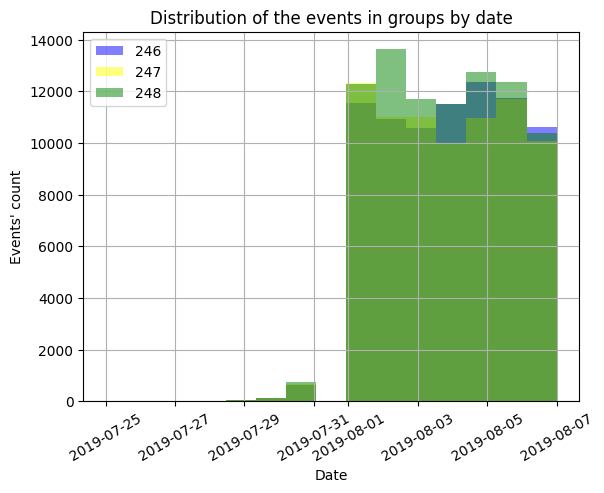

In [16]:
data[data['group'] == 246]['date'].hist(bins=15, alpha=0.5, color='blue', label=246)
data[data['group'] == 247]['date'].hist(bins=15, alpha=0.5, color='yellow', label=247)
data[data['group'] == 248]['date'].hist(bins=15, alpha=0.5, color='green', label=248)
plt.title('Distribution of the events in groups by date')
plt.xlabel('Date')
plt.ylabel("Events' count")
plt.xticks(rotation=30)
plt.legend()
plt.show()

According to the graph, despite having data from July 25th, the majority of the data is provided for the period from August 1st, 2019, to August 7th, 2018, meaning the experiment lasted exactly one week. Apparently, the data for the earlier period "arrived in the log" later. To avoid distorting the results, we will work with data dated from August 1st, 2019, onwards.

In [17]:
new_data = data[data['date'] >= dt.date(year=2019, month=8, day=1)]
print('Events count over the entire period:', data.shape[0])
print('Users count over the entire period:', data['user_id'].nunique())
print('Events count from 01-08-2019:', new_data.shape[0])
print('Users count from 01-08-2019:', new_data['user_id'].nunique())
print('Difference between events counts: ''{:.1%}'.format((new_data.shape[0]-data.shape[0])/data.shape[0]))
print('Difference between users counts: ''{:.1%}'.format((new_data['user_id'].nunique()-data['user_id'].nunique())/data['user_id'].nunique()))

Events count over the entire period: 243713
Users count over the entire period: 7551
Events count from 01-08-2019: 240887
Users count from 01-08-2019: 7534
Difference between events counts: -1.2%
Difference between users counts: -0.2%


If we discard data before 01-08-2019, the number of events will decrease by 1.2% (from 243,713 to 240,887), and the number of unique users will decrease by only 0.2% (from 7,551 to 7,534). Such changes will not have a significant impact on the test results, so the old data can be excluded from further analysis.

In [18]:
data = data[data['date'] >= dt.date(year=2019, month=8, day=1)]

In [19]:
data.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
246,2484
247,2513
248,2537


Each of the experimental groups contains users. Groups 246 and 247 contain 2,484 and 2,513 users, respectively, while group 248 has 2,537 users.

## Step 4. Events funnel analysis

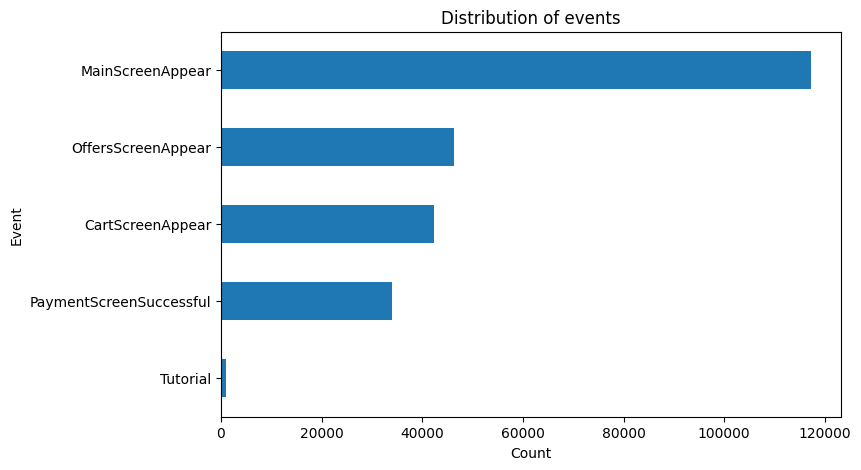

In [20]:
plt.figure(figsize=(8,5))
data.groupby('event_name')['user_id'].count().sort_values().plot(kind='barh')
plt.title('Distribution of events')
plt.xlabel('Count')
plt.ylabel('Event')
plt.show()

In [21]:
events_count = pd.DataFrame()
events_count['count'] = data.groupby('event_name')['user_id'].count()
events_count['percentage'] = (events_count['count'] / events_total * 100).round(2)
events_count = events_count.sort_values(by='percentage', ascending=False)
events_count

,count,percentage
event_name,,
MainScreenAppear,117328,48.14
OffersScreenAppear,46333,19.01
CartScreenAppear,42303,17.36
PaymentScreenSuccessful,33918,13.92
Tutorial,1005,0.41


The data contains 5 types of events:

- Tutorial - learning. The rarest event, constituting only 0.4% of the total. Users likely frequently skip it.

- MainScreenAppear - appearance of the main application screen. This event is the most common, accounting for a whopping 48% of the total.

- OffersScreenAppear - appearance of the offers screen. It represents 19% of the total number of events.

- CartScreenAppear - appearance of the cart screen. It accounts for 17% of the total.

- PaymentScreenSuccessful - appearance of the successful payment screen. The final step, almost 14% among all events.

In [22]:
user_events = data.groupby('event_name').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'user_count'}).sort_values(by='user_count')
user_events['percentage'] = (user_events['user_count'] / users_total * 100).round(2)
user_events['total'] = events_count['count']
user_events['unique_user_percentage'] = round(user_events['user_count'] / user_events['total'], 2)
user_events.sort_values(by='user_count', ascending=False)

,user_count,percentage,total,unique_user_percentage
event_name,,,,
MainScreenAppear,7419,98.25,117328,0.06
OffersScreenAppear,4593,60.83,46333,0.10
CartScreenAppear,3734,49.45,42303,0.09
PaymentScreenSuccessful,3539,46.87,33918,0.10
Tutorial,840,11.12,1005,0.84


The MainScreenAppear event is the most frequent, which is logical since it corresponds to opening the main page of the application. On the contrary, Tutorial is usually opened only once. The other events are repeated about 10 times on average.

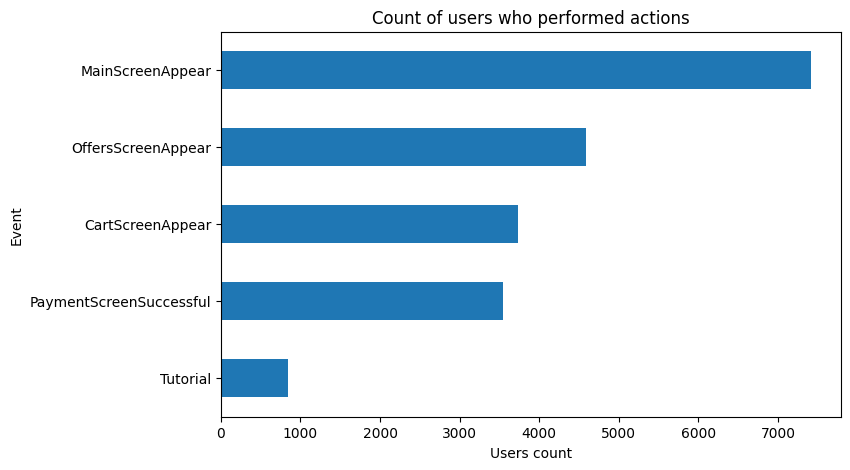

In [23]:
plt.figure(figsize=(8,5))
user_events['user_count'].plot(kind='barh')
plt.title('Count of users who performed actions')
plt.xlabel('Users count')
plt.ylabel('Event')
plt.show()

In [24]:
active_users = data.groupby('user_id', as_index=False).agg({'event_name': 'count'}).rename(columns={'event_name': 'count'})
active_users = len(active_users[active_users['count'] >= 1])
print(f"The share of users who have completed at least 1 event.: {'{0:.2f}'.format(active_users / users_total * 100)}%")

The share of users who have completed at least 1 event.: 99.77%


All events, except for the tutorial, form a sequential chain. Apparently, the tutorial appears at the first launch, but users skip it. It can be assumed that the application interface is already clear enough, so there is no need for a tutorial page. The next sequence of events is as follows:

<b>Main Screen Appear -> Offers Screen Appear -> Cart Screen Appear -> Payment Screen Successful</b>

Since the tutorial is not part of this sequence, we will exclude it from the funnel analysis.

In [25]:
funnel = user_events['user_count'].drop('Tutorial').sort_values(ascending=False).reset_index()
funnel['conv'] = (funnel['user_count'] / funnel['user_count'].max() * 100).round(2)
funnel['step_conv'] = None
for i in range(1, len(funnel)):
    funnel.loc[i, 'step_conv'] = round(funnel.loc[i, 'conv'] / funnel.loc[i - 1, 'conv'] * 100, 2)
funnel

,event_name,user_count,conv,step_conv
0,MainScreenAppear,7419,100.00,None
1,OffersScreenAppear,4593,61.91,61.91
2,CartScreenAppear,3734,50.33,81.3
3,PaymentScreenSuccessful,3539,47.70,94.77


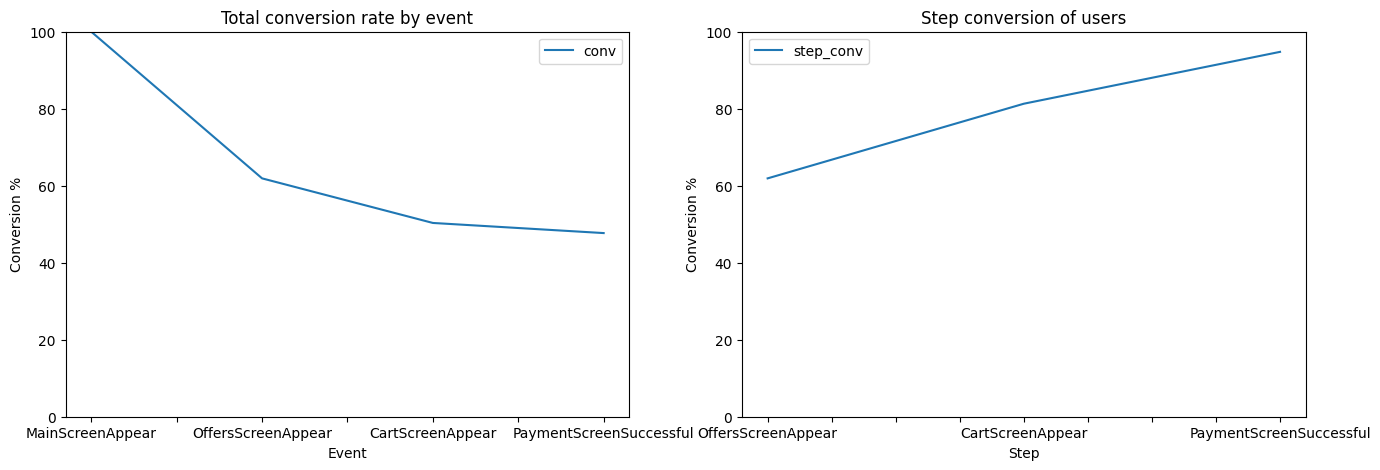

In [26]:
plt.figure(figsize=(16,5))
funnel.plot(kind='line', x='event_name', y='conv', title=('Total conversion rate by event'), ax=plt.subplot(1, 2, 1))
plt.ylim(0, 100)
plt.xlabel('Event')
plt.ylabel('Conversion %')
funnel[1:4].plot(kind='line', x='event_name', y='step_conv', title=('Step conversion of users'), ax=plt.subplot(1, 2, 2))
plt.xlabel('Step')
plt.ylabel('Conversion %')
plt.ylim(0, 100)
plt.show()

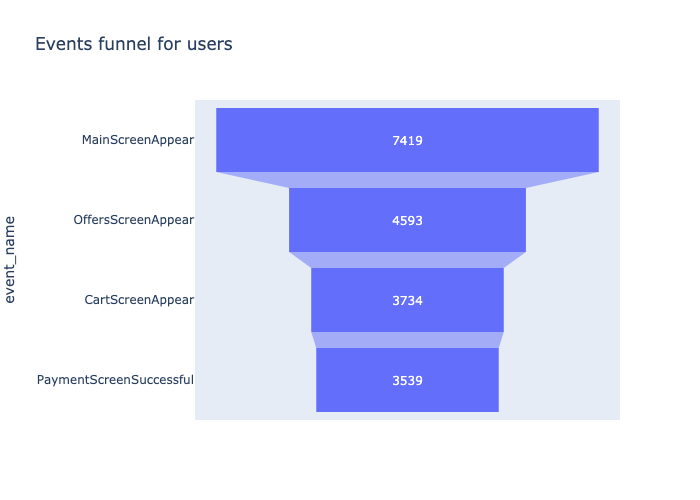

In [27]:
fig = px.funnel(funnel, x='user_count', y='event_name', title='Events funnel for users')
fig.show()

The majority of users, about 38%, drop off when transitioning from the main screen to the offers screen. Approximately 19% of users drop off at the cart screen step. Nearly 95% of users proceed from the cart to successful payment. In total, approximately 47.7% of users transition from the main screen to the successful payment screen.

Based on the funnel analysis, it can be concluded that more than a third of users do not proceed from the main screen to the product page. It's necessary to improve conversion at this stage, for example, by using a special offers banner on the main screen. Additionally, 19% of users view products but do not add them to the cart. The conversion rate at the payment step is quite high, with only 5% of customers not completing the payment after adding items to the cart.

## Step 5. Experiment Results Analysis

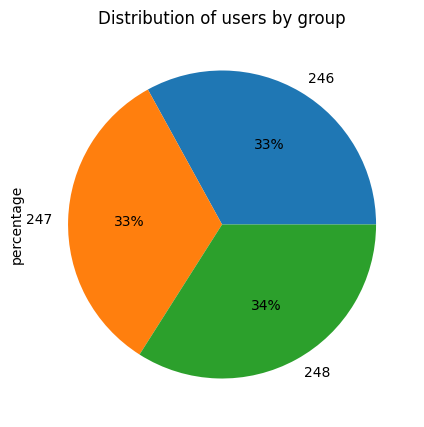

In [28]:
user_groups = data.groupby('group').agg({'user_id': 'nunique'})
user_groups['percentage'] = round(user_groups['user_id'] / users_total, 2)
plt.figure(figsize=(8,5))
user_groups['percentage'].plot(kind='pie', autopct='%d%%')
plt.title('Distribution of users by group')
plt.show()

In [29]:
user_groups

,user_id,percentage
group,,
246,2484,0.33
247,2513,0.33
248,2537,0.34


Users are evenly distributed among the groups: groups 246 and 247 each contain 33% of the users, while group 248 contains 34%.

In [30]:
mult_group_users = data.groupby('user_id').agg({'group': 'nunique'})
mult_group_users = mult_group_users[mult_group_users['group'] > 1]
print(f'Users, who ended up in several groups: {len(mult_group_users)}')

Users, who ended up in several groups: 0


There are no users in the data who are assigned to more than one group.

In [31]:
group_events = data.pivot_table(index='group', columns='event_name', values='user_id', aggfunc='nunique').reset_index()
user_groups = user_groups.reset_index()
group_events['total'] = user_groups['user_id']
group_events

event_name,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,total
0,246,1266,2450,1542,1200,278,2484
1,247,1238,2476,1520,1158,283,2513
2,248,1230,2493,1531,1181,279,2537


Let's test the hypotheses regarding the equality of proportions of users who completed different events in the control groups 246 and 247:

H0 - The proportions of users who completed the event are equal in groups 246 and 247.

H1 - The proportions of users who completed the events are different between groups 246 and 247.

We will set the statistical significance level at 0.05.

<Figure size 800x500 with 0 Axes>

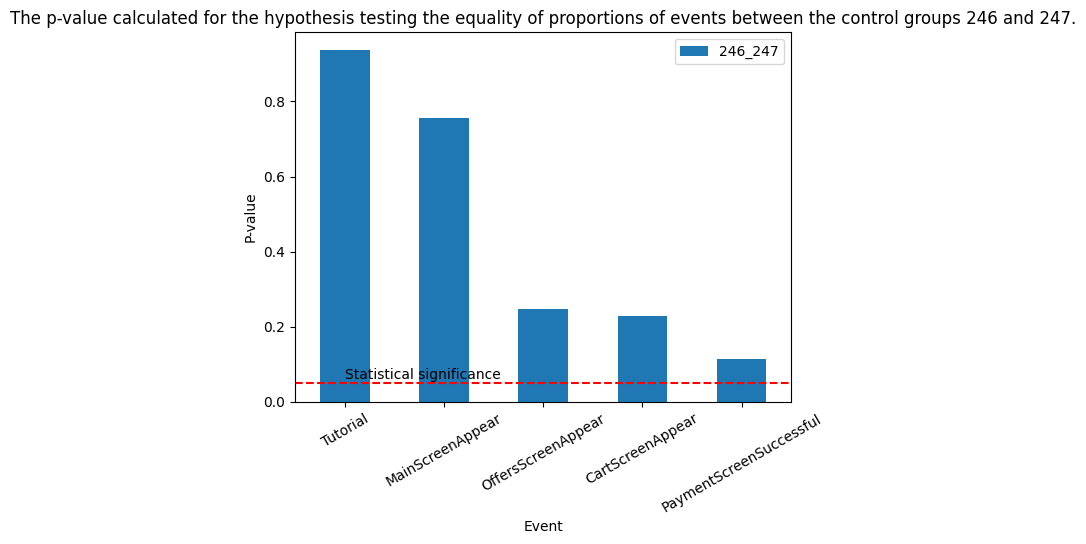

In [32]:
def event_stats(event: str, groups: list, alpha=0.05, message=False):
    g1 = group_events[group_events['group'] == groups[0]] 
    g2 = group_events[group_events['group'] == groups[1]] 
    leads1 = g1['total'].item()
    leads2 = g2['total'].item()
    clicks1 = g1[event].item()
    clicks2 = g2[event].item()
    p1 = clicks1 / leads1
    p2 = clicks2 / leads2
    p_combined = (clicks1 + clicks2) / (leads1 + leads2)
    difference = p1 - p2
    z_value = (difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                     (1/leads1 + 1/leads2)))
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if message:
        print('Statistical significance:', alpha)
        print('P-value:', p_value)
        if p_value < alpha:
            print('The null hypothesis is rejected.')
        else:
            print('The null hypothesis could not be rejected.')
    else:
        return p_value

alpha = 0.05

experiment_groups = pd.DataFrame()
experiment_groups['event_name'] = data['event_name'].unique()
experiment_groups['246_247'] = experiment_groups['event_name'].apply(event_stats, args=([246, 247],))

plt.figure(figsize=(8,5))
experiment_groups.plot(kind='bar', x='event_name', y='246_247')
plt.title('The p-value calculated for the hypothesis testing the equality of proportions of events between the control groups 246 and 247.')
plt.xlabel('Event')
plt.ylabel('P-value')
plt.xticks(rotation=30)
plt.axhline(y=alpha, color='red', linestyle='--')
plt.text(0, alpha + 0.01, 'Statistical significance')
plt.show()

As we can see from the graph, for each of the events, the p-value exceeds the level of statistical significance, indicating no grounds to reject the hypotheses of equality of proportions of users who performed each event between the control groups 246 and 247. The accuracy of calculations for the A/A experiment is confirmed.

<b>Now let's calculate the p-value for the same hypothesis, testing it on each pair of groups, including the group combining 246 and 247:</b>

In [33]:
experiment_groups['246_248'] = experiment_groups['event_name'].apply(event_stats, args=([246, 248],))
experiment_groups['247_248'] = experiment_groups['event_name'].apply(event_stats, args=([247, 248],))
combined = pd.DataFrame(group_events[0:2].sum()).T
group_events = pd.concat([group_events, combined]).reset_index(drop=True) # For convenience in calculations, the sum of groups 246 and 247 has been added to the dataframe
group_events

event_name,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,total
0,246,1266,2450,1542,1200,278,2484
1,247,1238,2476,1520,1158,283,2513
2,248,1230,2493,1531,1181,279,2537
3,493,2504,4926,3062,2358,561,4997


In [34]:
experiment_groups['246_248'] = experiment_groups['event_name'].apply(event_stats, args=([246, 248],))
experiment_groups['247_248'] = experiment_groups['event_name'].apply(event_stats, args=([247, 248],))
experiment_groups['246+247_248'] = experiment_groups['event_name'].apply(event_stats, args=([493, 248],))
experiment_groups.index = experiment_groups['event_name']
experiment_groups = experiment_groups.drop('event_name', axis=1)
experiment_groups

,246_247,246_248,247_248,246+247_248
event_name,,,,
Tutorial,0.937700,0.826429,0.765324,0.764862
MainScreenAppear,0.757060,0.294972,0.458705,0.294245
OffersScreenAppear,0.248095,0.208362,0.919782,0.434255
CartScreenAppear,0.228834,0.078429,0.578620,0.181759
PaymentScreenSuccessful,0.114567,0.212255,0.737342,0.600429


In [35]:
print('Testing hypothesis for groups 246 and 248:')
for event in experiment_groups.index:
    print('')
    print('Event:', event)
    event_stats(event, [246, 248], message=True)

Testing hypothesis for groups 246 and 248:

Event: Tutorial
Statistical significance: 0.05
P-value: 0.8264294010087645
The null hypothesis could not be rejected.

Event: MainScreenAppear
Statistical significance: 0.05
P-value: 0.2949721933554552
The null hypothesis could not be rejected.

Event: OffersScreenAppear
Statistical significance: 0.05
P-value: 0.20836205402738917
The null hypothesis could not be rejected.

Event: CartScreenAppear
Statistical significance: 0.05
P-value: 0.07842923237520116
The null hypothesis could not be rejected.

Event: PaymentScreenSuccessful
Statistical significance: 0.05
P-value: 0.2122553275697796
The null hypothesis could not be rejected.


In [36]:
print('Testing the hypothesis for groups 247 and 248:')
for event in experiment_groups.index:
    print('')
    print('Event:', event)
    event_stats(event, [247, 248], message=True)

Testing the hypothesis for groups 247 and 248:

Event: Tutorial
Statistical significance: 0.05
P-value: 0.765323922474501
The null hypothesis could not be rejected.

Event: MainScreenAppear
Statistical significance: 0.05
P-value: 0.4587053616621515
The null hypothesis could not be rejected.

Event: OffersScreenAppear
Statistical significance: 0.05
P-value: 0.9197817830592261
The null hypothesis could not be rejected.

Event: CartScreenAppear
Statistical significance: 0.05
P-value: 0.5786197879539783
The null hypothesis could not be rejected.

Event: PaymentScreenSuccessful
Statistical significance: 0.05
P-value: 0.7373415053803964
The null hypothesis could not be rejected.


In [37]:
print('Hypothesis testing for the combined control group and the experimental group.:')
for event in experiment_groups.index:
    print('')
    print('Event:', event)
    event_stats(event, [493, 248], message=True)

Hypothesis testing for the combined control group and the experimental group.:

Event: Tutorial
Statistical significance: 0.05
P-value: 0.764862472531507
The null hypothesis could not be rejected.

Event: MainScreenAppear
Statistical significance: 0.05
P-value: 0.29424526837179577
The null hypothesis could not be rejected.

Event: OffersScreenAppear
Statistical significance: 0.05
P-value: 0.43425549655188256
The null hypothesis could not be rejected.

Event: CartScreenAppear
Statistical significance: 0.05
P-value: 0.18175875284404386
The null hypothesis could not be rejected.

Event: PaymentScreenSuccessful
Statistical significance: 0.05
P-value: 0.6004294282308704
The null hypothesis could not be rejected.


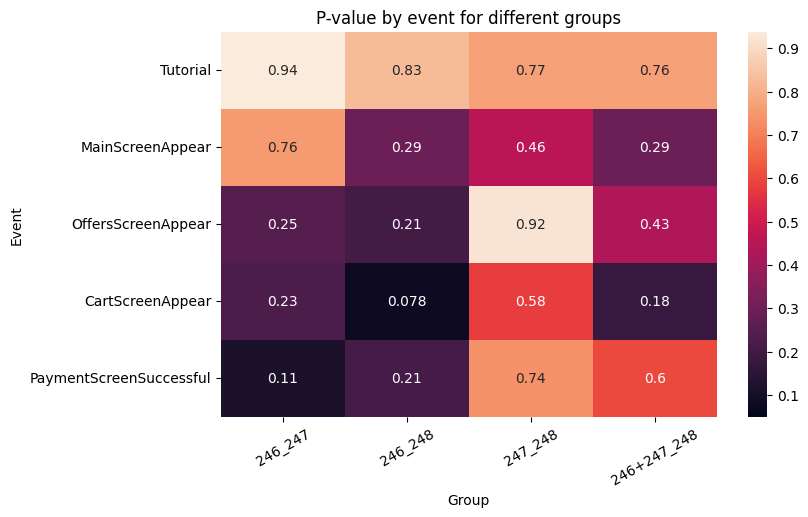

In [38]:
plt.figure(figsize=(8, 5))
sns.heatmap(experiment_groups, vmin=0.05, annot=True)
plt.title('P-value by event for different groups')
plt.xlabel('Group')
plt.ylabel('Event')
plt.xticks(rotation=30)
plt.show()

This heatmap displays the p-value calculated for each pair of groups and each event. Let's recall our hypothesis:

H0 - The proportions of users who perform the event are equal across groups.

H1 - The proportions of users who perform the event differ across groups.

According to the calculations, at a significance level of 0.05, the p-value exceeds it in each of the 20 cases. Thus, we can conclude that based on the statistical data, there is no reason to reject any of the 20 null hypotheses. Therefore, there is no evidence to suggest that the proportions of users performing each event differ between the control groups, between the control groups and the experimental group, as well as between the combined control group and the experimental group. It seems that changing fonts does not affect user behavior.

## Overall conclusion

As a result of the data analysis, the following conclusions can be drawn:

1) The analysis of the event funnel shows that 99.77% of users perform some actions in the application, with an average of 32 actions per user. Data was provided for 5 types of events. All of them, except the Tutorial event, form a sequential chain. Users first open the main application page, then proceed to the screen with offers. After selection, they add items to the cart and proceed to payment, resulting in the successful payment screen. It's worth noting that users often skip the Tutorial - only 11% view it. Overall, 47.7% of users reach the successful payment page. The event funnel demonstrates that a significant portion of users drop off at the main page, without accessing the offers. Thus, 38% of users are lost at this step. In this case, it is recommended to add an attractive banner, such as special offers, to redirect more users to the product page. Then, about 19% of users drop off before reaching the cart step. Finally, almost 95% of customers complete the purchase and reach the successful payment page.

2) The analysis of the experiment results conducted during the week from 01-08-2019 to 07-08-2019 revealed that users are evenly distributed across groups, with no cases of users belonging to multiple groups. The A/A test confirmed the correctness of group distribution by showing statistical equality in the control groups. Testing the hypothesis of equality of the proportion of events between different groups showed that there is no difference in the frequency of events between the main and experimental groups, meaning no event occurred more or less frequently as a result of font changes in the application. It can be concluded that users do not care about the font used in the interface, and it does not affect their purchases.

In conclusion, the data preprocessing and exploratory analysis were successfully conducted. The objectives of the study were achieved after analyzing the event funnel and the results of the A/A/B experiment. Necessary conclusions were made regarding user actions and the impact of fonts in the application on their behavior.